# selection of stations


In [ ]:
stn_df = pd.read_csv(r"G:\fresh_start\paper\code_paper\main_data\final_data\daily_avg_1962.csv")

all_npl_stn_list = pd.read_excel(r"G:\fresh_start\paper\code_paper\main_data\raw_data\Meteorological_station_list.xlsx")
all_npl_stn_list = all_npl_stn_list.rename(columns={"Index No.": "station"})
# Extract unique stations with regions, latitude, longitude, and elevation
unique_stations = stn_df[['station', 'regions', 'lat', 'long', 'elevation']].drop_duplicates()

# Display the unique station info
filtered_data = pd.merge(unique_stations, all_npl_stn_list, on='station', how='left')
#all_npl_stn_list[all_npl_stn_list['Index No.'].isin(unique_stations['station'])]
selected_columns = ['station','Station Name', 'regions', 'lat', 'long', 'elevation']
filtered_data = filtered_data[selected_columns]
filtered_data.loc[filtered_data['station'] == 9999, 'Station Name' ] = 'Lubuche'
#filtered_data.to_csv(r"G:\fresh_start\paper\code_paper\main_data\final_data\final_stations_koshi.csv", index=False)


# map

In [1]:
import pykrige
import numpy as np
from geopandas.tools import sjoin
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging
from shapely.geometry import Point
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, DrawingArea, OffsetBox
import contextily as cx
from eomaps import Maps
import matplotlib.patches as mpatches


In [2]:
# Step 1: Read the shapefile
shapefile_path = r'G:\fresh_start\paper\code_paper\arcgis\koshibasin\physiographic_koshi\koshi_5_physiographic.shp'
gdf_basin = gpd.read_file(shapefile_path)

stations_path = r'G:\fresh_start\paper\code_paper\main_data\final_data\final_stations_koshi.csv'
stations = pd.read_csv(stations_path)


# Create a GeoDataFrame
geometry = [Point(xy) for xy in zip(stations['long'], stations['lat'])]
gdf_stations = gpd.GeoDataFrame(stations, geometry=geometry)

# Set coordinate reference system (CRS) if known; otherwise, default is EPSG:4326
gdf_stations.crs = "EPSG:4326"

In [4]:
# Rename the column 'DESCRIPTIO' to 'DESCRIPTION'
gdf_basin = gdf_basin.rename(columns={'DESCRIPTIO': 'DESCRIPTION'})
# Replace values in the 'DESCRIPTION' column
gdf_basin['DESCRIPTION'] = gdf_basin['DESCRIPTION'].replace({
    'High Mountain': 'Himalaya',
    'Middle Mountain': 'High Mountain',
    'Hill': 'Middle Mountain'
})

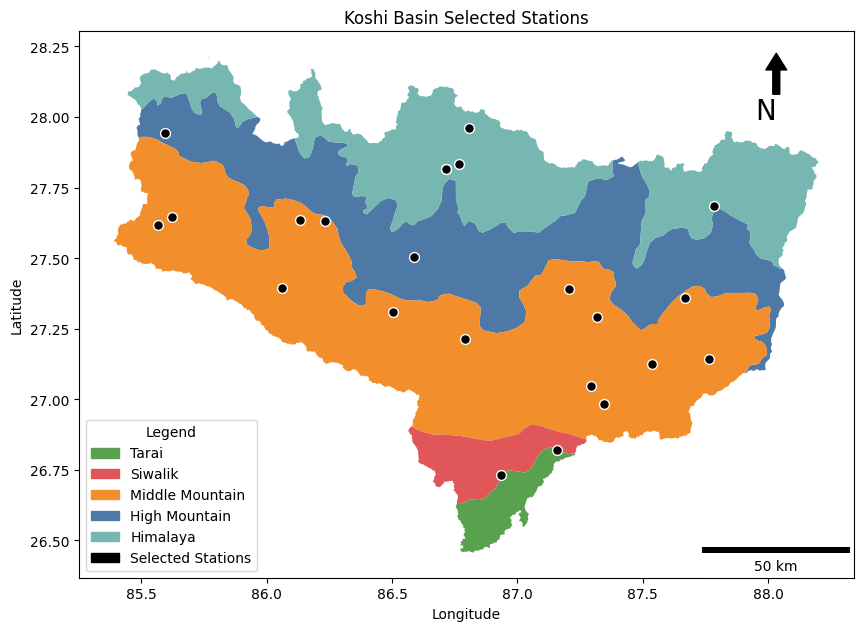

In [8]:

# Step 4: Plot the data
fig, ax = plt.subplots(figsize=(10, 10), alpha = 0.5, edgecolor = "k")

color_map = {
    'Tarai': '#59A14F',            # Natural Green
    'Siwalik': '#E15759',          # Soft Red
    'Middle Mountain': '#F28E2B',             # Warm Orange
    'High Mountain': '#4E79A7',  # Soft Blue
    'Himalaya': '#76B7B2',    # Gentle Teal
    
}

for regions, data in gdf_basin.groupby('DESCRIPTION'):
    color = color_map[regions]
    data.plot(
        color=color,
        ax=ax,
        )


# Plot the stations
gdf_stations.plot(ax=ax, color='black', markersize=50, edgecolor='white', label='Selected Stations')
# Add legend


# Add titles and labels
ax.set_title('Koshi Basin Selected Stations')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')


# Add a scale bar

points = gpd.GeoSeries(
    [Point(-73.5, 40.5), Point(-74.5, 40.5)], crs=4326
)  # Geographic WGS 84 - degrees
points = points.to_crs(32619)
distance_meters = points[0].distance(points[1])
ax.add_artist(ScaleBar((distance_meters), location ="lower right"))


x, y, arrow_length = 0.9, 0.96, 0.08
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='right', va='top', fontsize=20,
            xycoords=ax.transAxes)


# Step 2: Create custom legend handles for the regions and stations

# Handles for the regions
legend_handles_regions = [mpatches.Patch(color=color, label=region) for region, color in color_map.items()]

# Handle for the stations
legend_handle_stations = mpatches.Patch(color='black', label='Selected Stations')

# Combine both sets of handles
all_legend_handles = legend_handles_regions + [legend_handle_stations]

# Add the combined legend
ax.legend(handles=all_legend_handles, title="Legend", loc='lower left', bbox_to_anchor=(0, 0))

ax.grid(False)

plt.savefig(r"G:\fresh_start\paper\code_paper\plots\study_area\koshi_basin_selected_station_study_area_map.png", dpi=1500, bbox_inches='tight')
# Show plot
plt.show()